In [1]:
from Models.framework_utils import *
from Models.diagnostic_utils import *

# load numerapi
public_id, secret_key = get_numerapi_config()
napi, modelnameids = get_napi_and_models(public_id, secret_key)

# load data
ds_version = "v4.2"
dataset_loc = os.path.join(os.getcwd(), 'train_datasets', ds_version)
currentRound = get_update_training_data(napi, dataset_loc, ds_version)

Please enter your Numerai ID and Key in created config.json and restart


SystemExit: 

c:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
np.random.seed(42)
print("# Loading data... ",end='')

# training data T* | X = features, I = era indices
train, TI, targets = processData(os.path.join(dataset_loc, 'train_int8.parquet'), return_target_names=True)

with open(os.path.join(dataset_loc, "features.json"), "r") as f:
    feature_metadata = json.load(f)

# validation data V*
validation, VI = processData(os.path.join(dataset_loc, 'validation_int8.parquet'), return_target_names=False)

with open(os.path.join(dataset_loc, "features.json"), "r") as f:
    feature_metadata = json.load(f)
feature_sets = feature_metadata['feature_sets']

BVP = pd.read_parquet(os.path.join(dataset_loc, 'validation_benchmark_models.parquet'),engine="fastparquet")

gc.collect()
print("done")

# Loading data... done


In [4]:
import lightgbm

params = {"n_estimators": 200, # 2000
          "learning_rate": 0.1, # 0.01
          "max_depth": 4, # 5
          "num_leaves": 2 ** 4 - 1, # 2 ** 5 - 1
          "colsample_bytree": 0.10} # 0.1

lgbm_model = lightgbm.LGBMRegressor(**params)

lgbm_model.fit(train[feature_sets['all_features']], train['target'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10660
[LightGBM] [Info] Number of data points in the train set: 2420521, number of used features: 2132
[LightGBM] [Info] Start training from score 0.500015


LGBMRegressor(colsample_bytree=0.1, max_depth=4, n_estimators=200,
              num_leaves=15)

In [5]:
VP = lgbm_model.predict(validation[feature_sets['all_features']])

s:\DS Projects\Numerai - Automated Submission Framework\Models\diagnostic_utils.py:58: RuntimeWarning: invalid value encountered in divide
  return prod / np.sqrt(ddiffs2 * idiff2)


corrv2 mean : 0.025622
corrv2 sdev : 0.021301
corrv2 sharpe : 1.202844
corrv2 sortino (-0.02) : 0.440595
corrv2 drawdown : -0.201821
fnc mean : 0.019519
fnc sdev : 0.017621
fnc sharpe : 1.107743
fnc sortino (-0.02) : -0.036069
fnc drawdown : -0.144855
mean abs feature exposure : 0.056096
max abs feature exposure : 0.197284
sdev feature exposure : 0.030659
example_preds corr (preds) mean : 0.764939
example_preds corr (preds) sdev : 0.039614


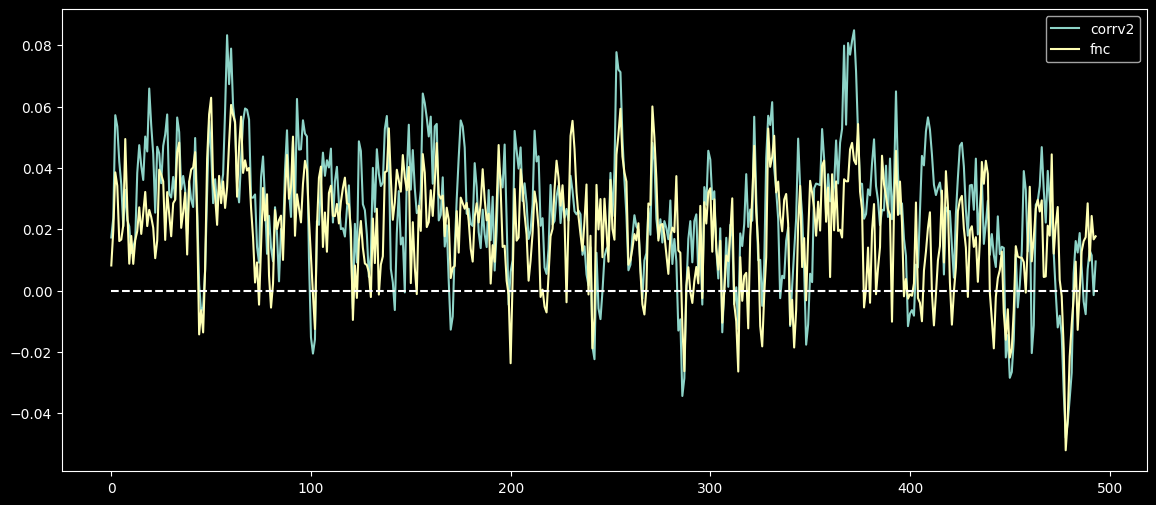

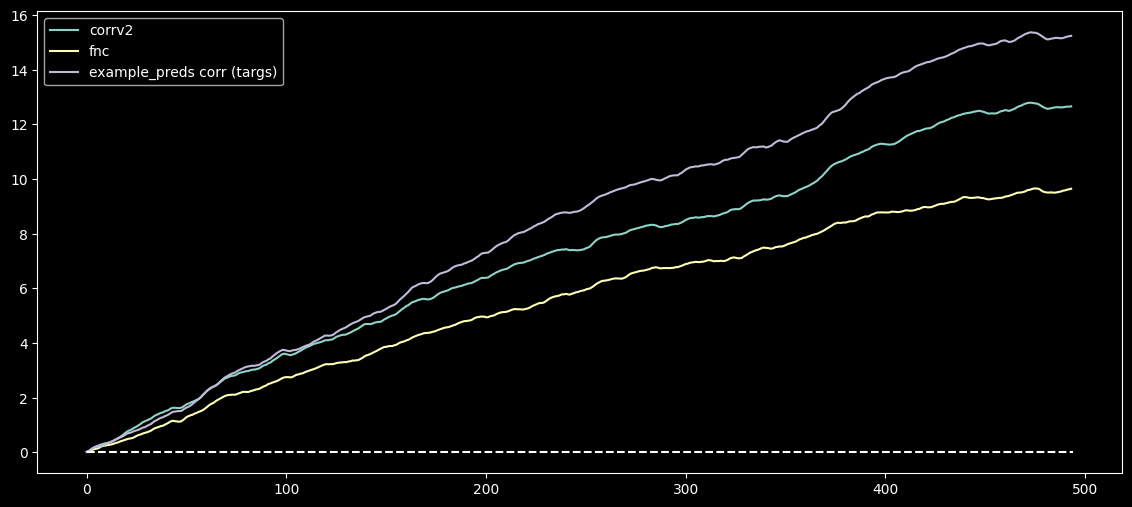

In [15]:
VId = VI[5:-5] # remove first 5 eras of validation to prevent lookahead bias from the training data, remove last 5 as they are unresolved
validation_diagnostics, validation_corrs = run_diagnostics(VP,validation['target'],validation[feature_sets['fnc_v3_features']], VId, featexp=True, fnc=True, 
                                                           print_output=True, graph_corrs=True, compare={'example_preds': BVP['v42_teager_plus_cyrus']})

In [16]:
lgbm_model.booster_.save_model(os.path.join(os.getcwd(), 'Models', 'Modeldata', 'lgbm_model.txt'))
np.save(os.path.join(os.getcwd(), 'Models', 'Modeldata', 'lgbm_model_features.npy'), feature_sets['all_features'])